# Homework 6
 
**Harvard University**<br>
**Spring 2018**<br>
**Instructors: Rahul Dave**<br>
**Due Date: ** Friday, March 9th, 2018 at 11:00am

**Instructions:**

- Upload your iPython notebook containing all work to Canvas.

- Structure your notebook and your work to maximize readability.

In [1]:
import numpy as np
import pandas as pd
from copy import deepcopy
import time
from functools import partial

import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d, Axes3D

import seaborn as sns
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('talk')
%matplotlib inline

## Problem 1: Metropolis and Chill

Suppose we ask you to memorize the order of the top five movies on IMDB. When we quiz you on the order afterwards, you might not recall the correct order, but the mistakes you will tend to make in your recall can be modeled by simple probabilistic models.
  
Let's say that the top five movies are:  
1. *The Shawshank Redemption*
2. *The Godfather*
3. *Wonder Woman*
4. *Black Panther*
5. *Pulp Fiction*

Let's represent this ordering by the vector $\omega = (1,2,3,4,5)$. 

If you were to mistakenly recall the top five movies as:
2. *The Godfather*
3. *Wonder Woman*
5. *Pulp Fiction*
4. *Black Panther*
1. *The Shawshank Redemption*

We'd represent your answer by the vector $\theta = (2,3,5,4,1)$.

Now, we have a way of quantifying how wrong your answer can be. We define the Hamming distance between two top five rankings, $\theta, \omega$, as follows:
$$d(\theta, \omega) = \sum_{i=1}^5 \mathbb{I}_{\theta_i\neq \omega_i},$$ 
where $\mathbb{I}_{\theta_i\neq \omega_i}$ is the indicator function that returns 1 if $\theta_i\neq \omega_i$, and 0 otherwise.

For example, the Hamming distance between your answer and the correct answer is $d(\theta, \omega)=4$, because you only ranked *Black Panther* in both answers correctly. 

Finally, let's suppose that the probability of giving a particular answer (expressed as $\theta$) is modeled as
$$ p(\theta \,|\, \omega, \lambda) \propto  e^{-\lambda\, d(\theta,\, \omega)}.$$

### Part A:

Implement an Metropolis algorithm to produce sample guesses from 500 individuals, with various $\lambda$ values, $\lambda=0.2, 0.5, 1.0$. What are the top five possible guesses?

### Part B:
Using the Metropolis algorithm, compute the probability that *The Shawshank Redemption* is ranked as the top movie (ranked number 1) . Compare the resulting probabilities for the various different $\lambda$ values. Summarize your findings.

### Answer to Problem 1 Part A

In [2]:
w_correct = np.array([1, 2, 3, 4, 5], dtype=int)

def prob(w, lam):
    return np.exp(-lam * np.sum(w != w_correct))

def q_draw(x):
    x = x.copy()
    np.random.shuffle(x)
    return x

x_init = np.array([2, 3, 5, 4, 1], dtype=int)

In [3]:
def unique_count(samples):
    d = dict()
    for s in samples:
        s = str(s)
        d[s] = d.get(s, 0) + 1
    return sorted(d.items(), key=lambda x:x[1], reverse=True)

def get_hamming_dist(x1, x2):
    return np.sum(x1 != x2)

def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])
    
def show_summary(m):
    print('lambda: {}'.format(m.lam))
    print('Acceptance rate: {}'.format(m.accepted_ratio))
    plt.figure(figsize=(10, 3))
    plt.subplot(1, 2, 1)
    corrplot(m.samples_dist)
    plt.title('Before burnin and thining')
    plt.subplot(1, 2, 2)
    corrplot(m.samples2_dist)
    plt.title('After burnin and thining')

class Metropolis:
    def __init__(self, lam=0.2, dim=5):
        self.lam = lam
        self.dim = dim
    
    def run(self, p, q_draw, n, x_init):
        start = time.time()
        p = partial(prob, lam=self.lam)
        samples = np.empty((n, self.dim), dtype=int)
        x_prev = x_init
        accepted = 0
        for i in range(n):
            x_star = q_draw(x_prev)
            p_star = p(x_star)
            p_prev = p(x_prev)
            pdfratio = p_star / p_prev
            if np.random.uniform() < min(1, pdfratio):
                samples[i] = x_star
                x_prev = x_star
                accepted += 1
            else:
                samples[i] = x_prev
        self.x_init = x_init
        self.n = n
        self.accepted = accepted
        self.accepted_ratio = accepted / n
        self.samples = samples
        self.samples_prob = np.array([p(x) for x in samples])
        self.samples_dist = np.array([get_hamming_dist(w_correct, x) for x in samples])
        self.time_ = time.time() - start
        return self
    
    def process(self, burnin=10000, thin=100):
        self.samples2 = self.samples[burnin::thin]
        self.samples2_prob = self.samples_prob[burnin::thin]
        self.samples2_dist = self.samples_dist[burnin::thin]
        return self
    
    def top_counts(self):
        self.count = unique_count(self.samples2)
        return self

After serval trials, we decide to run the sampler for 60000 iterations, discard 10000 samples for burnin, and thin the rest every 100 samples.

In [4]:
%%time
n = 60000
m1 = Metropolis(lam=0.2).run(None, q_draw, n, x_init).process().top_counts()
m2 = Metropolis(lam=0.5).run(None, q_draw, n, x_init).process().top_counts()
m3 = Metropolis(lam=1).run(None, q_draw, n, x_init).process().top_counts()

Wall time: 7.88 s


We can first plot the autocorrelation of hamming distance of samples (compared to the correct order) before and after burnin and thining for each case.

lambda: 0.2
Acceptance rate: 0.8891333333333333


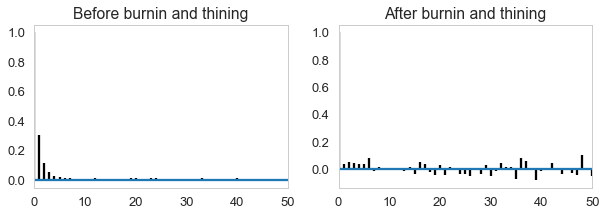

In [5]:
show_summary(m1)

lambda: 0.5
Acceptance rate: 0.703


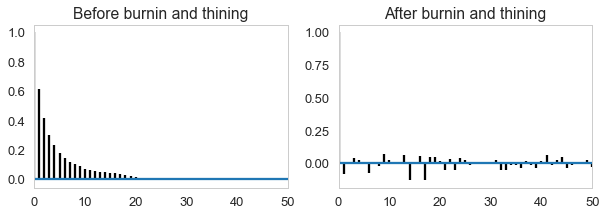

In [6]:
show_summary(m2)

lambda: 1
Acceptance rate: 0.37023333333333336


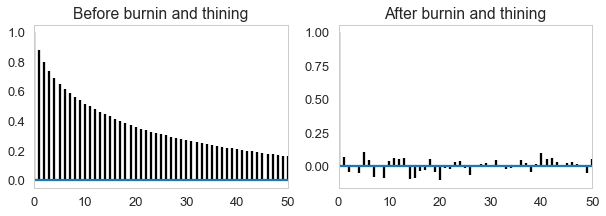

In [7]:
show_summary(m3)

**Observations**:
1. Acceptance rate decreases as $\lambda$ increases. It is reasonable since larger $\lambda$ would result in more punishment (more decrease in probability) for larger number of incorrect guesses in general.
2. Autocorrelation is more serious for larger $\lambda$, presumably due to lower acceptance rate.
3. Burning and thining help eliminate autocorrelations in all cases.

The histograms of hamming distances of samples (compared to the correct order) are shown as follows.

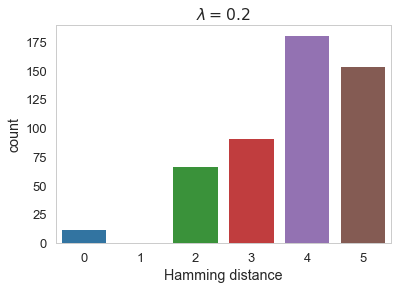

In [8]:
sns.countplot(m1.samples2_dist, order=[0, 1, 2, 3, 4, 5]);
plt.xlabel('Hamming distance');
plt.title('$\lambda={}$'.format(m1.lam));

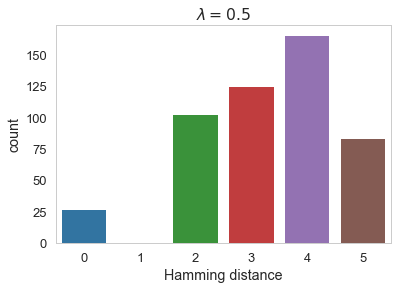

In [9]:
sns.countplot(m2.samples2_dist, order=[0, 1, 2, 3, 4, 5]);
plt.xlabel('Hamming distance');
plt.title('$\lambda={}$'.format(m2.lam));

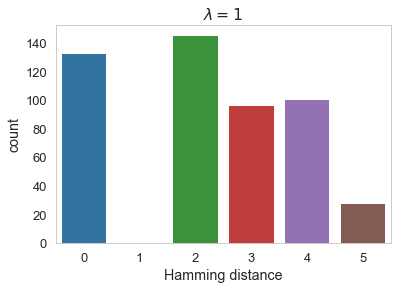

In [10]:
sns.countplot(m3.samples2_dist, order=[0, 1, 2, 3, 4, 5]);
plt.xlabel('Hamming distance');
plt.title('$\lambda={}$'.format(m3.lam));

In [11]:
print('lambda: {}'.format(m1.lam))
print('Top 5 posible guesses and their counts (from 500 samples):')
print(m1.count[:5])
print()
print('lambda: {}'.format(m2.lam))
print('Top 5 posible guesses and their counts (from 500 samples):')
print(m2.count[:5])
print()
print('lambda: {}'.format(m3.lam))
print('Top 5 posible guesses and their counts (from 500 samples):')
print(m3.count[:5])

lambda: 0.2
Top 5 posible guesses and their counts (from 500 samples):
[('[3 2 1 4 5]', 14), ('[1 2 3 4 5]', 11), ('[1 2 4 3 5]', 11), ('[4 2 3 1 5]', 11), ('[5 4 2 3 1]', 10)]

lambda: 0.5
Top 5 posible guesses and their counts (from 500 samples):
[('[1 2 3 4 5]', 26), ('[5 2 3 4 1]', 17), ('[1 2 3 5 4]', 15), ('[4 2 1 3 5]', 13), ('[1 5 3 4 2]', 11)]

lambda: 1
Top 5 posible guesses and their counts (from 500 samples):
[('[1 2 3 4 5]', 132), ('[1 2 5 4 3]', 18), ('[4 2 3 1 5]', 17), ('[2 1 3 4 5]', 17), ('[1 2 3 5 4]', 16)]


As we can see, the ratio of correct guesses is higher for larger $\lambda$, which is consistent with target distributions we set.

### Answer to Problem 1 Part B

In [12]:
print('The probability that The Shawshank Redemption is ranked as the top movie (500 samples):')
print('(lambda = {}) the probability is {:.4f}.'.format(m1.lam, np.mean([s[0] == 1 for s in m1.samples2])))
print('(lambda = {}) the probability is {:.4f}.'.format(m2.lam, np.mean([s[0] == 1 for s in m2.samples2])))
print('(lambda = {}) the probability is {:.4f}.'.format(m3.lam, np.mean([s[0] == 1 for s in m3.samples2])))

The probability that The Shawshank Redemption is ranked as the top movie (500 samples):
(lambda = 0.2) the probability is 0.2260.
(lambda = 0.5) the probability is 0.3340.
(lambda = 1) the probability is 0.5660.


As we can see, the probability that *The Shawshank Redemption* is ranked as the top movie is higher for larger $\lambda$. The distribution would "centralize" towards the correct guess for large $\lambda$, and the probaility that the first movie is ranked correctly would thus be higher for larger $\lambda$.

In summary, we have the following findings for problem 1:
1. Acceptance rate decreases as $\lambda$ increases. It is reasonable since larger $\lambda$ would result in more punishment (more decrease in probability) for larger number of incorrect guesses in general.
2. Autocorrelation is more serious for larger $\lambda$, presumably due to lower acceptance rate.
3. Burning and thining help eliminate autocorrelations in all cases.
4. The probability of correct guesses is higher for larger $\lambda$, which is consistent with target distributions we set.
5. The probability that *The Shawshank Redemption* is ranked as the top movie is higher for larger $\lambda$, which is consistent with target distributions we set.

## Problem 2: Lensed Galaxies via Metropolis-Hastings

You are a renowned observational astronomer working on gravitational lensing and you just got news about a source whose morphology appears distorted, most likely because there is a foreground source (an ensemble of mini black holes for which you know the mass and position) acting as a lens. Your gravitational lensing calculations indicate that the detected flux $F$ from the background source as a function of right ascencion ($x$) and declination ($y$) can be described by a modified Beale's function:

$F(x,y) = \exp\left[-\left(\frac{x^2}{2\sigma_x^2}+\frac{y^2}{2\sigma_y^2}\right)\right] \log (1.0+(1.5-x+xy)^2+(2.25-x+xy^2)^2+(2.625-x+xy^3)^2) $

with $\sigma_x = \sigma_y = \sqrt{10}$

You are interested in observing this source with the Hubble Space Telescope, and you want to simulate beforehand how photons will form the image on the Hubble detector. You realize that a good way to do this is by sampling F(x,y) with a Monte Carlo method.

### Part A:

Using the following asymmetric function as a proposal distribution:

$q(x,y) = \frac{1}{\sqrt{2 \pi \gamma_1\gamma_2}} {\rm exp}\left[-\left(\frac{(x-0.1)^2}{2 \gamma_1^2} + \frac{(y-0.1)^2}{2 \gamma_2^2}\right) \right] $ 

with $\gamma_1 = 1.0\beta$, $\gamma_2 = 1.5\beta$, and $\beta=1$ (x and y are the coordinates of the proposed step if we center the coordinate system in our current position.)

construct a Metropolis-Hastings algorithm to produce $N=100,000$ samples from $F(x,y)$ with an initial position of $(x,y) = (5,-5)$. Plot the results.

### Part B:

We want to experiment with $\beta$ by running your code with $\beta$ in the range 0.1 to 40 (think about the appropriate order of magnitude of the $\beta$ spacing). 

1. Plot the accepted sample histories for each $\beta$. What is the acceptance rate for each $\beta$? 
2. Explain your results and select the "best" value of $\beta$?

### Part C:

Choose a symmetric proposal and construct a Metropolis algorithm to product $N=100,000$ samples from $F(x,y)$ with an initial position of $(x,y) = (5,-5)$. Plot the results.  How do the results compare to those from Metropolis-Hastings in **Parts A & B**?  

### Answer to Problem 2 Part A

In [13]:
def F(x, sigma2=10):
    return np.exp(-np.sum(np.square(x))/2/sigma2) * np.log(1 + (1.5-x[0]+x[0]*x[1])**2 \
                                                           + (2.25-x[0]+x[0]*x[1]*x[1])**2 \
                                                           + (2.625-x[0]+x[0]*x[1]**3)**2)

def q_draw(x, gamma1=1, gamma2=1.5):
    return x + np.random.multivariate_normal([0.1, 0.1], [[gamma1**2, 0], [0, gamma2**2]])

def q_pdf(x, x_old, gamma1=1, gamma2=1.5):
    return np.exp(-((x[0]-x_old[0]-0.1)**2/2/gamma1**2 \
                    + (x[1]-x_old[1]-0.1)**2/2/gamma2**2)) / (2 * np.pi * gamma1 * gamma2)


class Metropolis_Hastings:
    def __init__(self, beta=1, dim=2):
        self.dim = dim
        self.p = F
        self.q_draw = partial(q_draw, gamma1=beta, gamma2=1.5*beta)
        self.beta = beta
        self.q_pdf = partial(q_pdf, gamma1=beta, gamma2=1.5*beta)
    
    def run(self, n=100000, x_init=np.array([5, -5])):
        start = time.time()
        p = self.p
        q_draw = self.q_draw
        q_pdf = self.q_pdf
        samples = np.empty((n, self.dim))
        x_prev = x_init
        accepted = 0
        for i in range(n):
            x_star = q_draw(x_prev)
            p_star = p(x_star)
            p_prev = p(x_prev)
            pdfratio = p_star / p_prev
            proposalratio = q_pdf(x_prev, x_star) / q_pdf(x_star, x_prev)
            if np.random.uniform() < min(1, pdfratio * proposalratio):
                samples[i] = x_star
                x_prev = x_star
                accepted += 1
            else:
                samples[i] = x_prev
        self.x_init = x_init
        self.n = n
        self.accepted = accepted
        self.accepted_ratio = accepted / n
        self.samples = samples
        self.samples_prob = np.array([p(x) for x in samples])
        self.time_ = time.time() - start
        return self
    
    def process(self, burnin, thin):
        self.burnin = burnin
        self.thin = thin
        self.samples2 = self.samples[burnin::thin]
        self.samples2_prob = self.samples_prob[burnin::thin]
        return self

In [14]:
def corrplot(trace, maxlags=50):
    plt.acorr(trace-np.mean(trace),  normed=True, maxlags=maxlags);
    plt.xlim([0, maxlags])

def corrplots(mh):
    print('beta = {}'.format(mh.beta))
    plt.figure(figsize=(10, 8))
    plt.subplot(2, 2, 1)
    corrplot(mh.samples[:, 0])
    plt.ylabel('autocorrelation($x$)')
    plt.title('No burnin and thining')
    plt.subplot(2, 2, 2)
    corrplot(mh.samples[:, 1])
    plt.ylabel('autocorrelation($y$)')
    plt.title('No burnin and thining')
    plt.subplot(2, 2, 3)
    corrplot(mh.samples2[:, 0])
    plt.ylabel('autocorrelation($x$)')
    plt.title('burnin = {}, thining = {}'.format(mh.burnin, mh.thin))
    plt.subplot(2, 2, 4)
    corrplot(mh.samples2[:, 1])
    plt.ylabel('autocorrelation($y$)')
    plt.title('burnin = {}, thining = {}'.format(mh.burnin, mh.thin))
    plt.tight_layout()
    
def traceplots(mh):
    print('beta = {}'.format(mh.beta))
    plt.figure(figsize=(10, 12))
    plt.subplot(3, 2, 1)
    plt.plot(mh.samples[:-1, 0], alpha=0.3)
    plt.ylabel('$x$')
    plt.title('No burnin and thining')
    plt.subplot(3, 2, 2)
    plt.plot(mh.samples[:, 1], alpha=0.3)
    plt.ylabel('$y$')
    plt.title('No burnin and thining')
    
    plt.subplot(3, 2, 3)
    plt.plot(mh.samples[:len(mh.samples2), 0], alpha=0.3)
    plt.ylabel('$x$')
    plt.title('No burnin and thining')
    plt.subplot(3, 2, 4)
    plt.plot(mh.samples[:len(mh.samples2), 1], alpha=0.3)
    plt.ylabel('$y$')
    plt.title('No burnin and thining')
    
    plt.subplot(3, 2, 5)
    plt.plot(mh.samples2[:, 0], alpha=0.3)
    plt.ylabel('$x$')
    plt.title('burnin = {}, thining = {}'.format(mh.burnin, mh.thin))
    plt.subplot(3, 2, 6)
    plt.plot(mh.samples2[:, 1], alpha=0.3)
    plt.ylabel('$y$')
    plt.title('burnin = {}, thining = {}'.format(mh.burnin, mh.thin))
    plt.tight_layout()

In [15]:
%%time
mh = Metropolis_Hastings(beta=1).run(n=100000, x_init=np.array([5, -5]))
print('Acceptance rate is {}.'.format(mh.accepted_ratio))

Acceptance rate is 0.76097.
Wall time: 26.6 s


After several trials, we found burnin at 10000 and thining at 70 did reasonably well in eliminating autocorrelations.

beta = 1
Wall time: 345 ms


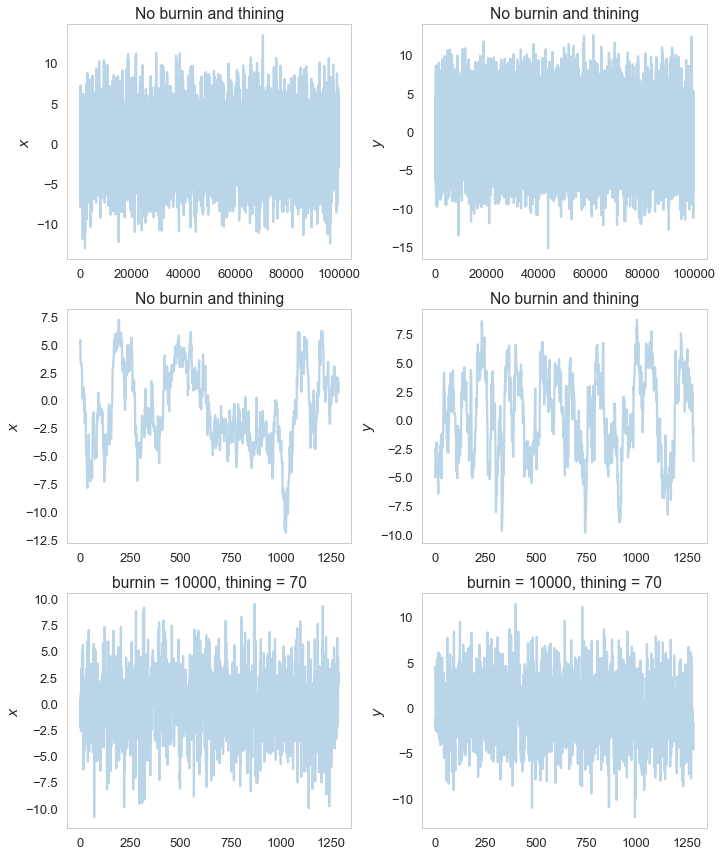

In [16]:
%%time
mh.process(10000, 70)
traceplots(mh)

beta = 1
Wall time: 6.15 s


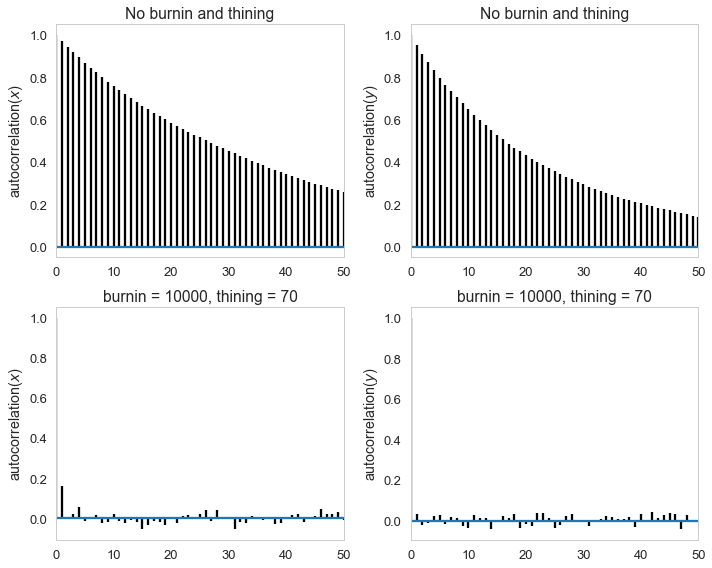

In [17]:
%%time
corrplots(mh)

Strong autocorrelations are observed, but can be eliminated by thining at a large interval.

We can plot results before and after burnin and thining as follows.

No burnin and thining.
Wall time: 522 ms


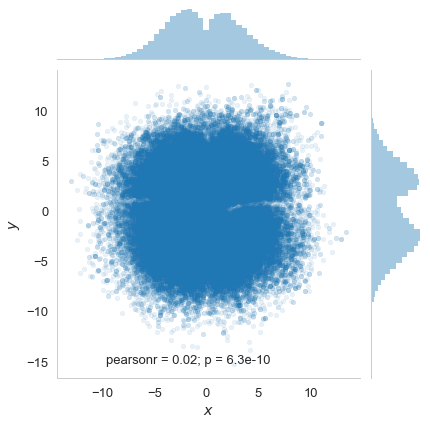

In [18]:
%%time
print('No burnin and thining.')
g = sns.jointplot(x=0, y=1, data=pd.DataFrame(mh.samples), marker='.');
g.ax_joint.collections[0].set_alpha(0.1);
g.set_axis_labels('$x$', '$y$');

No burnin and thining.
Wall time: 1min 10s


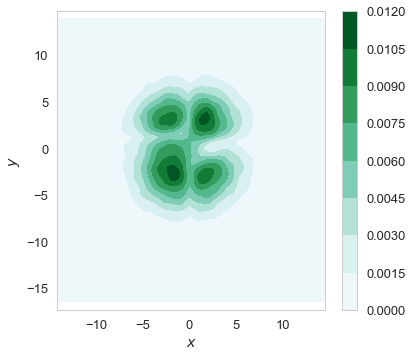

In [19]:
%%time
print('No burnin and thining.')
plt.figure(figsize=(6, 5.5))
sns.kdeplot(mh.samples[:, 0], mh.samples[:, 1], shade=True, cbar=True);
plt.xlabel('$x$');
plt.ylabel('$y$');
plt.axis('equal');

burnin = 10000, thining = 70
Wall time: 220 ms


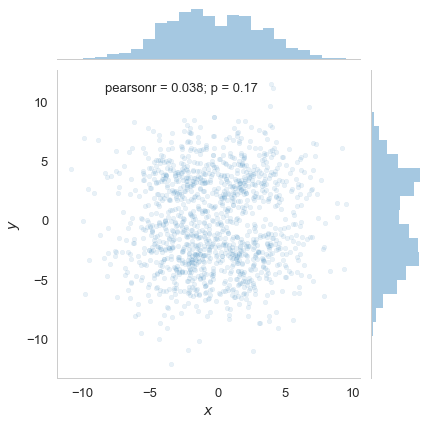

In [20]:
%%time
print('burnin = {}, thining = {}'.format(mh.burnin, mh.thin))
g = sns.jointplot(x=0, y=1, data=pd.DataFrame(mh.samples2), marker='.');
g.ax_joint.collections[0].set_alpha(0.1);
g.set_axis_labels('$x$', '$y$');

burnin = 10000, thining = 70
Wall time: 1.17 s


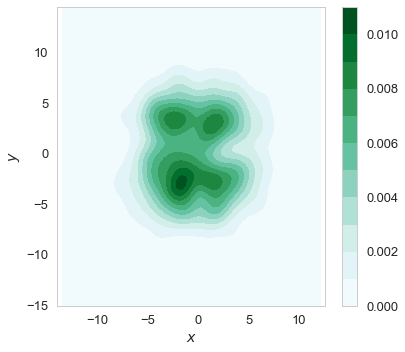

In [21]:
%%time
print('burnin = {}, thining = {}'.format(mh.burnin, mh.thin))
plt.figure(figsize=(6, 5.5))
sns.kdeplot(mh.samples2[:, 0], mh.samples2[:, 1], shade=True, cbar=True);
plt.xlabel('$x$');
plt.ylabel('$y$');
plt.axis('equal');

Although there are much less points after burnin and thining, the distributions seem to be similar. Since the autocorrelations are strong, indicating $\beta$ = 1 is not a good choice. We don't further sample more to get 100,000 samples after burin and thining in this case.

### Answer to Problem 2 Part B

#### 1. Plot the accepted sample histories for each $\beta$. What is the acceptance rate for each $\beta$? 

In [22]:
%%time
betas = [0.1, 0.2, 0.5, 1, 2, 5, 10, 20, 40]
mhs = []

for b in betas:
    print('beta = {}:'.format(b))
    mhs.append(Metropolis_Hastings(beta=b).run(n=100000, x_init=np.array([5, -5])))
    print('Acceptance rate: {}.'.format(mhs[-1].accepted_ratio))

beta = 0.1:
Acceptance rate: 0.23062.
beta = 0.2:
Acceptance rate: 0.54418.
beta = 0.5:
Acceptance rate: 0.77263.
beta = 1:
Acceptance rate: 0.76272.
beta = 2:
Acceptance rate: 0.63484.
beta = 5:
Acceptance rate: 0.34935.
beta = 10:
Acceptance rate: 0.13837.
beta = 20:
Acceptance rate: 0.04032.
beta = 40:
Acceptance rate: 0.0111.
Wall time: 3min 30s


The acceptance rate increases when $\beta$ increases from 0.1 to 0.5, and decreases when $\beta$ increases from 0.5 to 40. In general, lower acceptance rate is expected for larger step size (i.e., larger $\beta$). In this case, the "offset" in the proposal function plays a significant role in lowering the acceptance rate when $\beta$ is too small; thus we observe positive correlation between acceptance rate and $\beta$ for the first few small $\beta$s. We observe negative correlation between acceptance rate and $\beta$ when $\beta$ is large enough to counteract the effect of the "offset" in the proposal function.

For each $\beta$, we tune burnin and thining, and plot the trace plots and autocorrelations as follows.

beta = 0.1


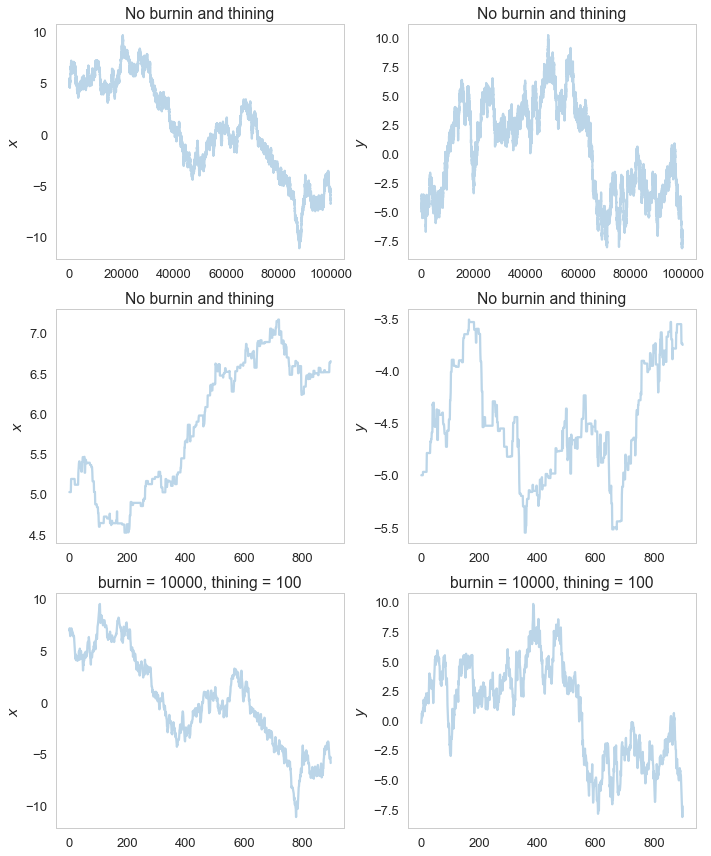

In [23]:
mhs[0].process(10000, 100)
traceplots(mhs[0])

beta = 0.1
Wall time: 5.87 s


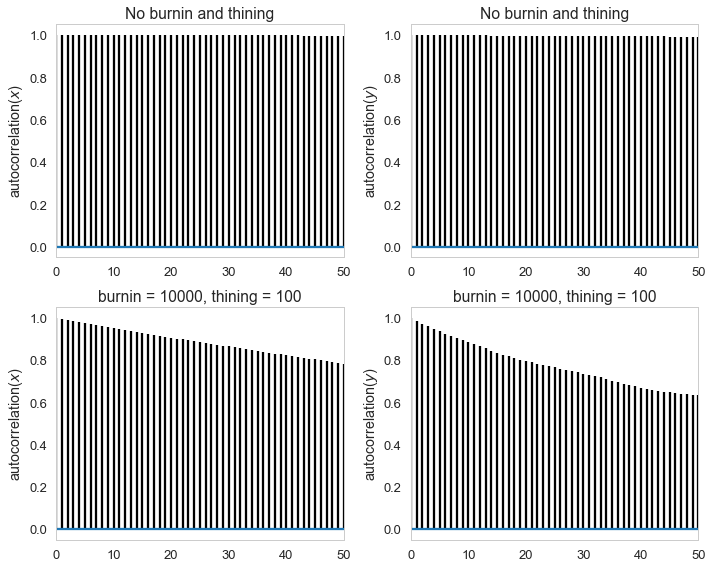

In [24]:
%%time
corrplots(mhs[0])

We observe strong autocorrelation even if we set thining to be 100, indicating $\beta$ = 0.1 is too small.

beta = 0.2


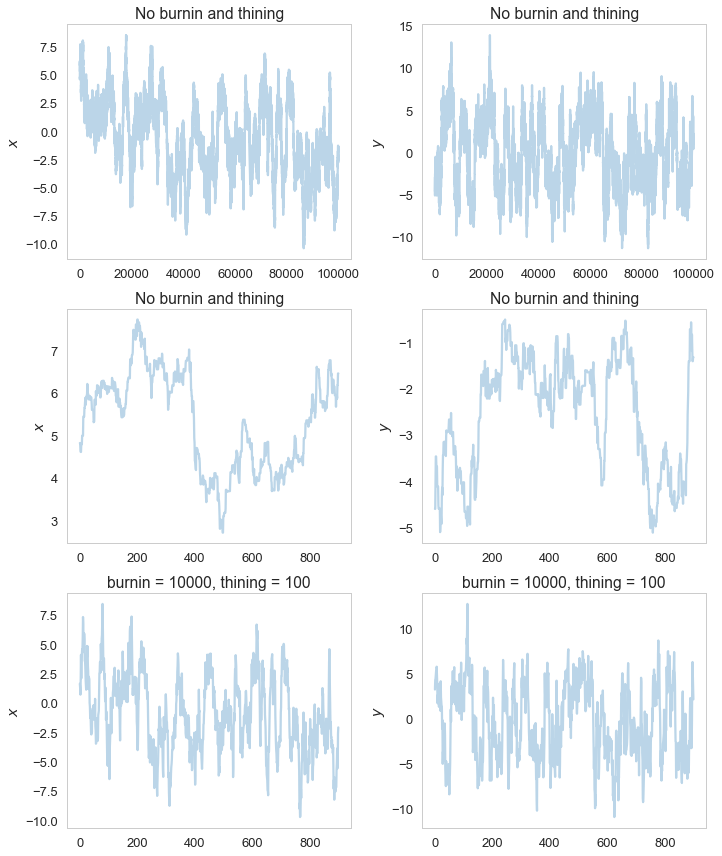

In [25]:
mhs[1].process(10000, 100)
traceplots(mhs[1])

beta = 0.2


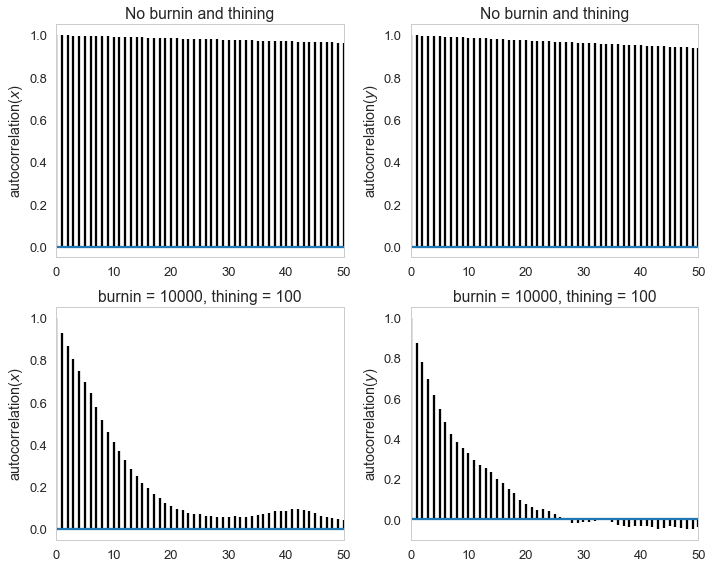

In [26]:
corrplots(mhs[1])

$\beta$ = 0.2 is better than $\beta$ = 0.1 in terms of autocorrelations, but still, $\beta$ = 0.2 is too small.

beta = 0.5


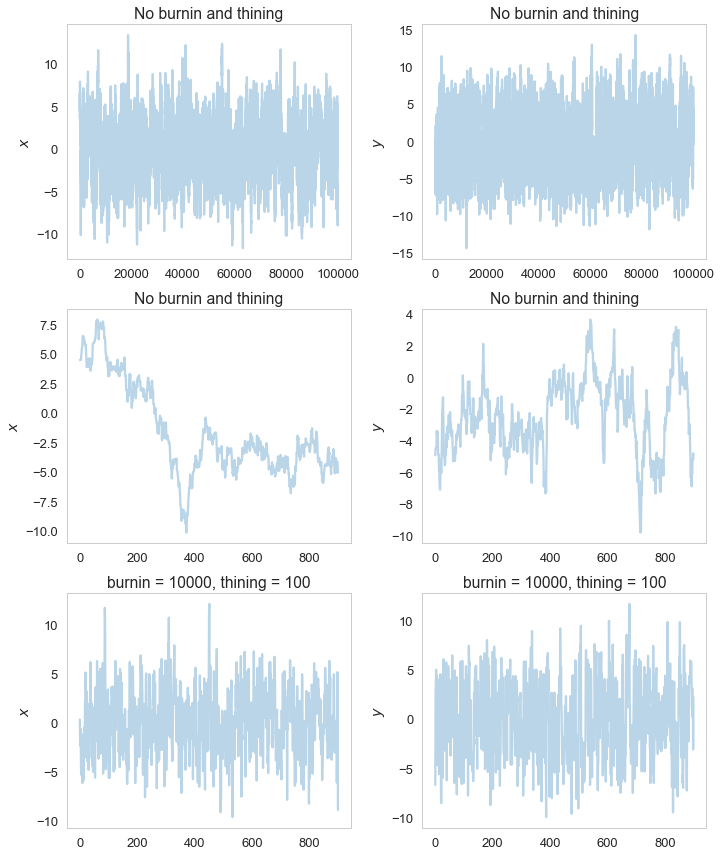

In [27]:
mhs[2].process(10000, 100)
traceplots(mhs[2])

beta = 0.5


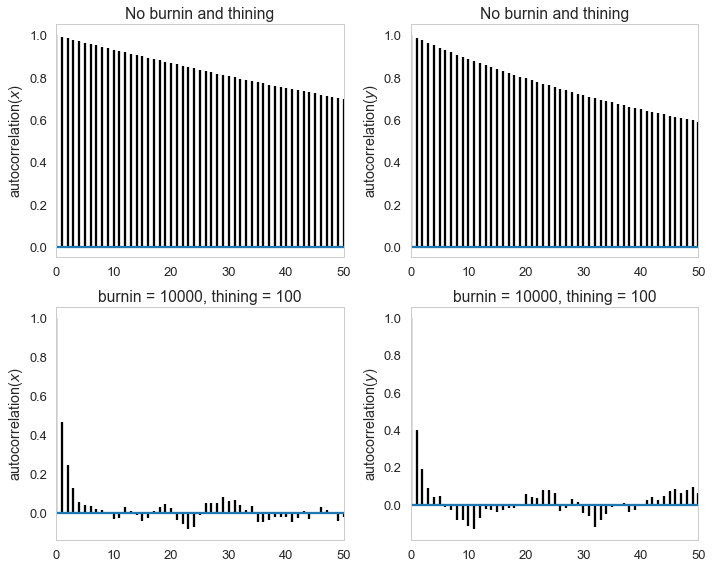

In [28]:
corrplots(mhs[2])

It is better than first 2 $\beta$s.

beta = 1


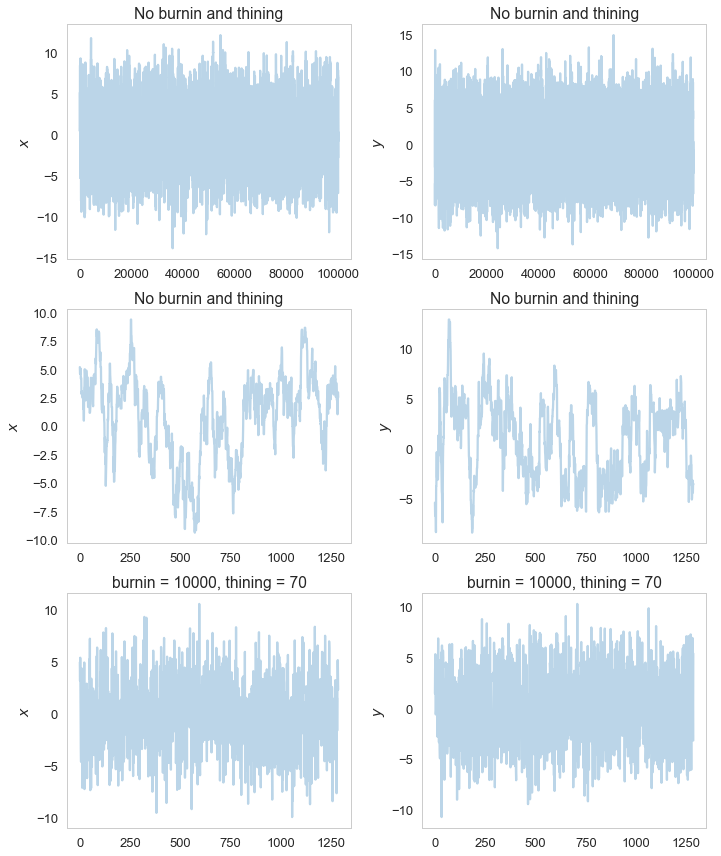

In [29]:
mhs[3].process(10000, 70)
traceplots(mhs[3])

beta = 1


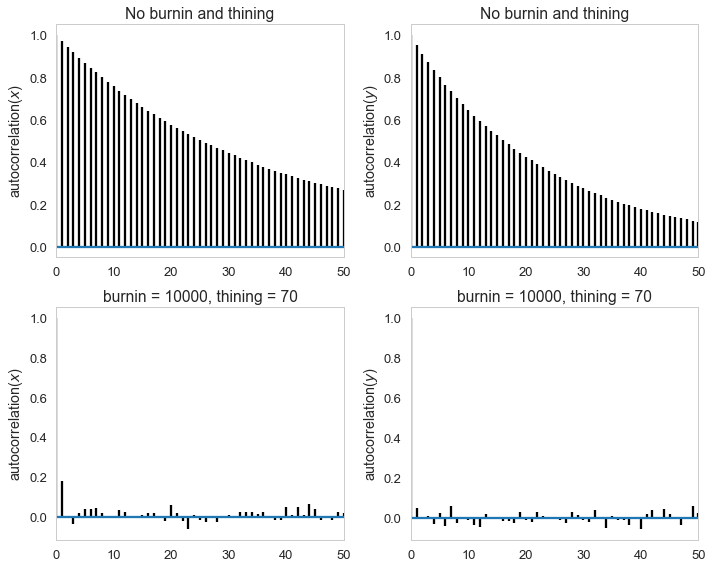

In [30]:
corrplots(mhs[3])

Autocorrelations are still very strong when $\beta$ = 1.

beta = 2


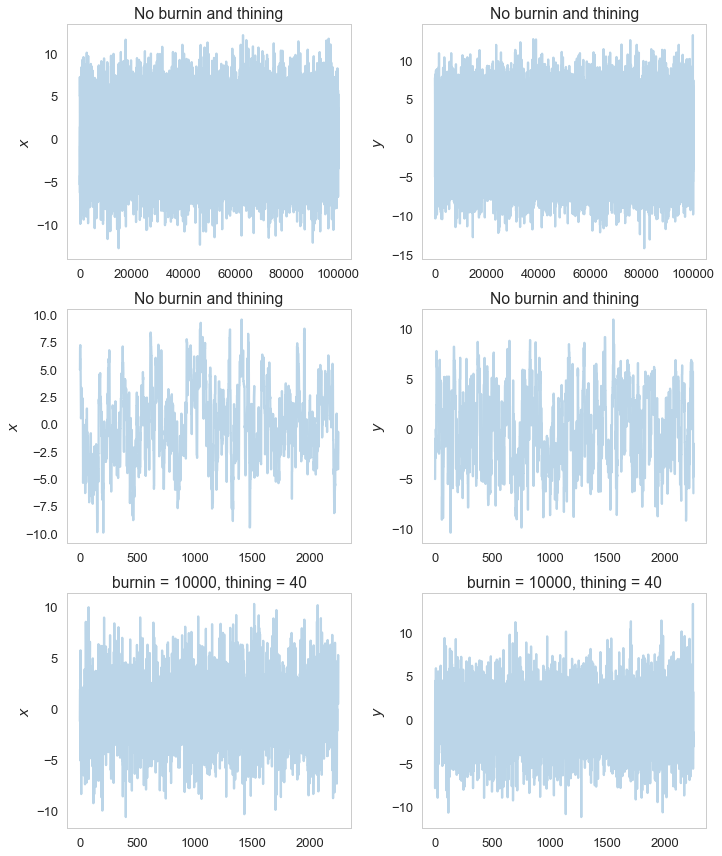

In [31]:
mhs[4].process(10000, 40)
traceplots(mhs[4])

beta = 2


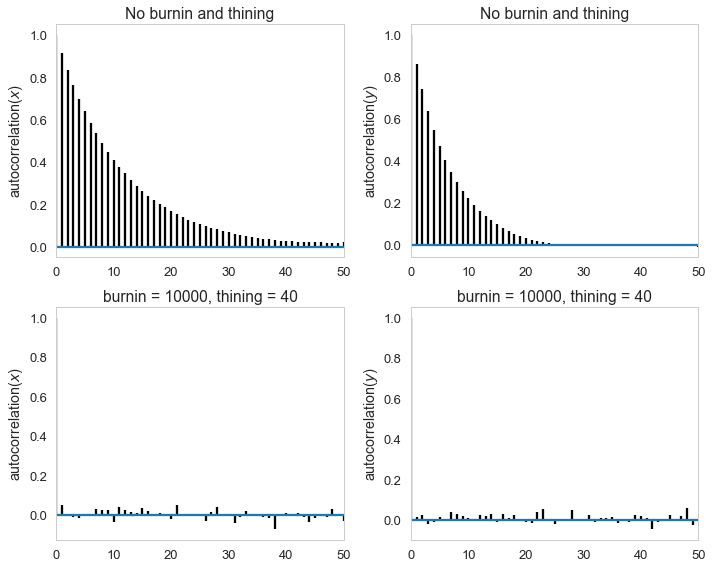

In [32]:
corrplots(mhs[4])

We can further lower thining while maintaining negligible autocorrelations.

beta = 5


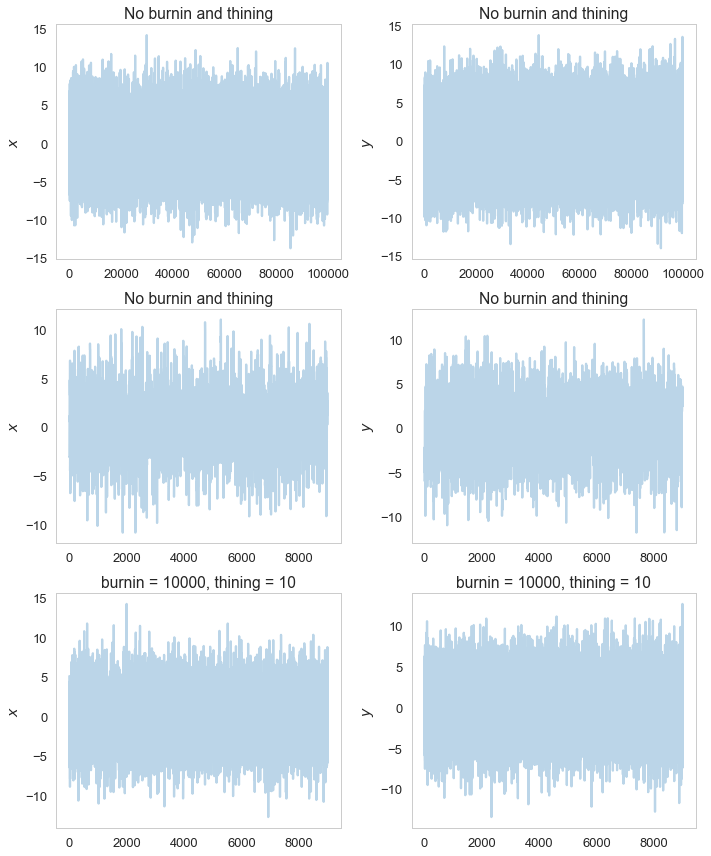

In [33]:
mhs[5].process(10000, 10)
traceplots(mhs[5])

beta = 5


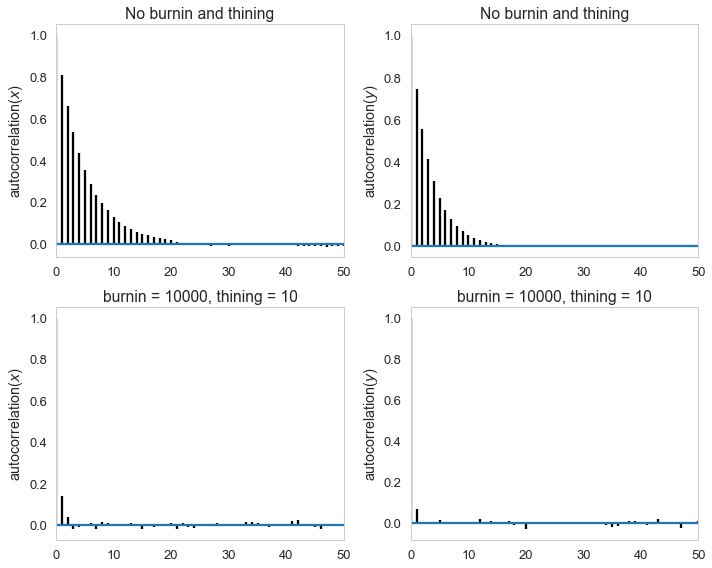

In [34]:
corrplots(mhs[5])

The autocorrelations are significantly weaker than previous cases. We can further decrease thining to 10 when $\beta$ = 5.

beta = 10


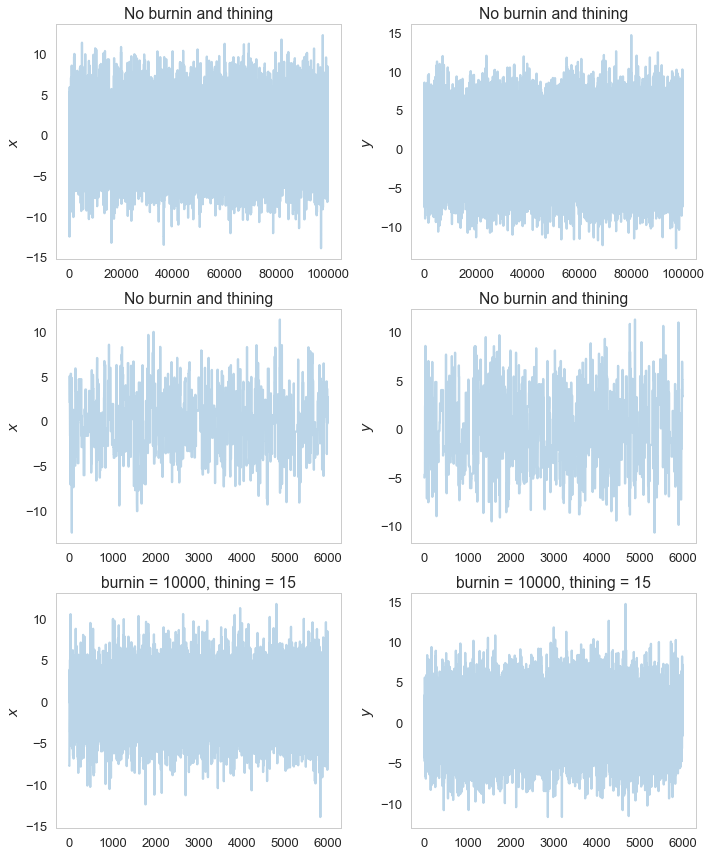

In [35]:
mhs[6].process(10000, 15)
traceplots(mhs[6])

beta = 10


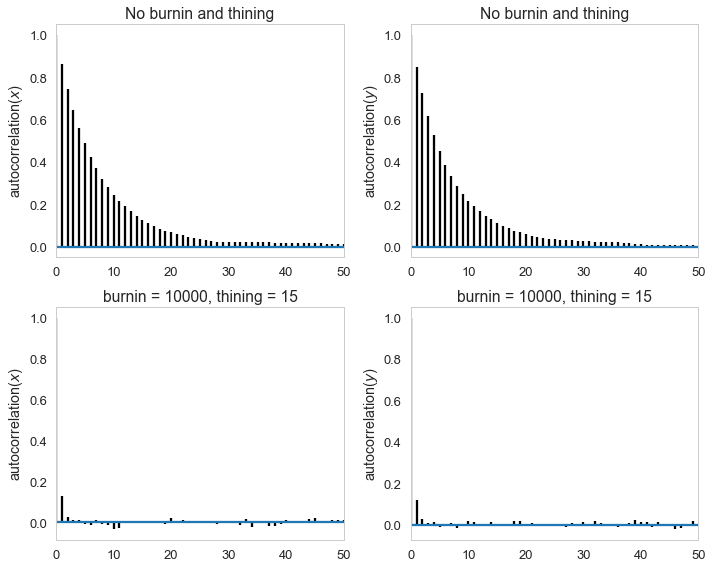

In [36]:
corrplots(mhs[6])

When $\beta$ = 10, we need to increase thining to 15 to maintain the same level of auto correlations.

beta = 20


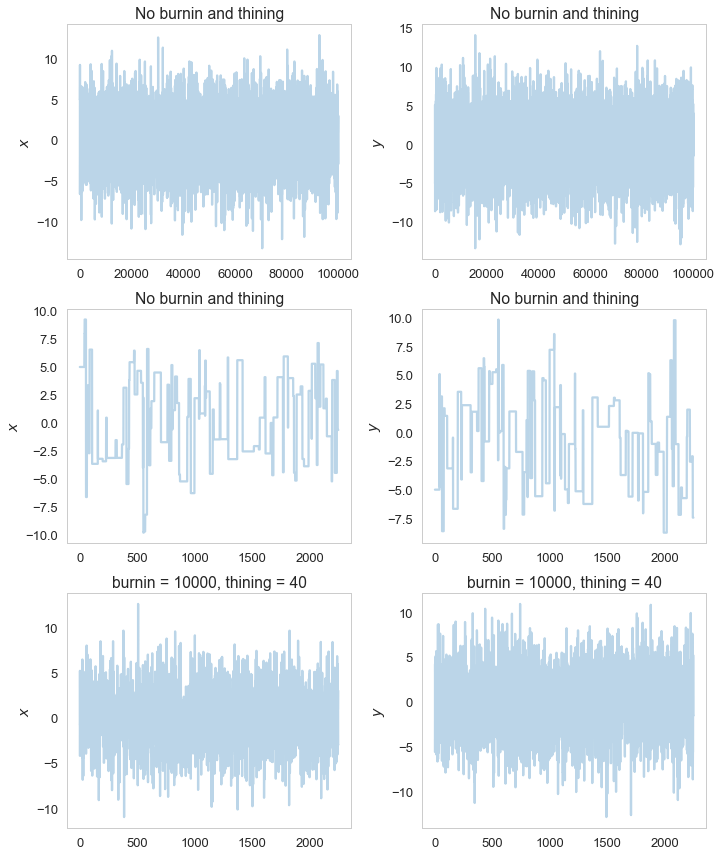

In [37]:
mhs[7].process(10000, 40)
traceplots(mhs[7])

beta = 20


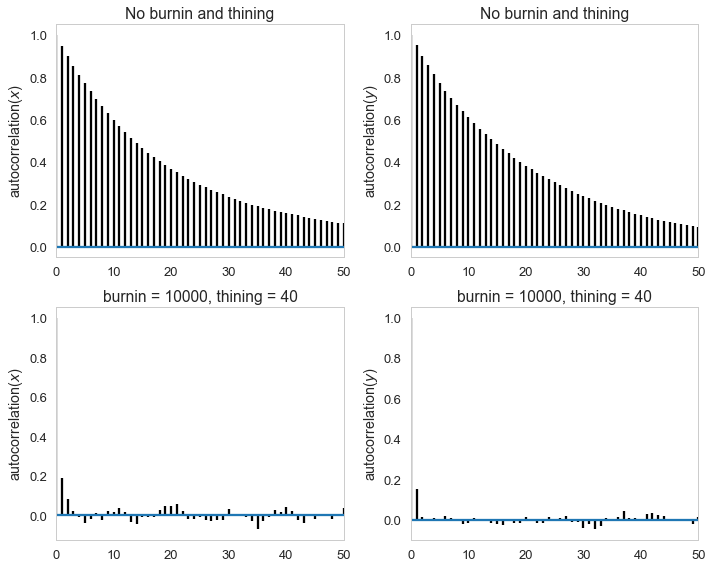

In [38]:
corrplots(mhs[7])

Autocorrelations are stronger. We need to further increase thining.

beta = 40


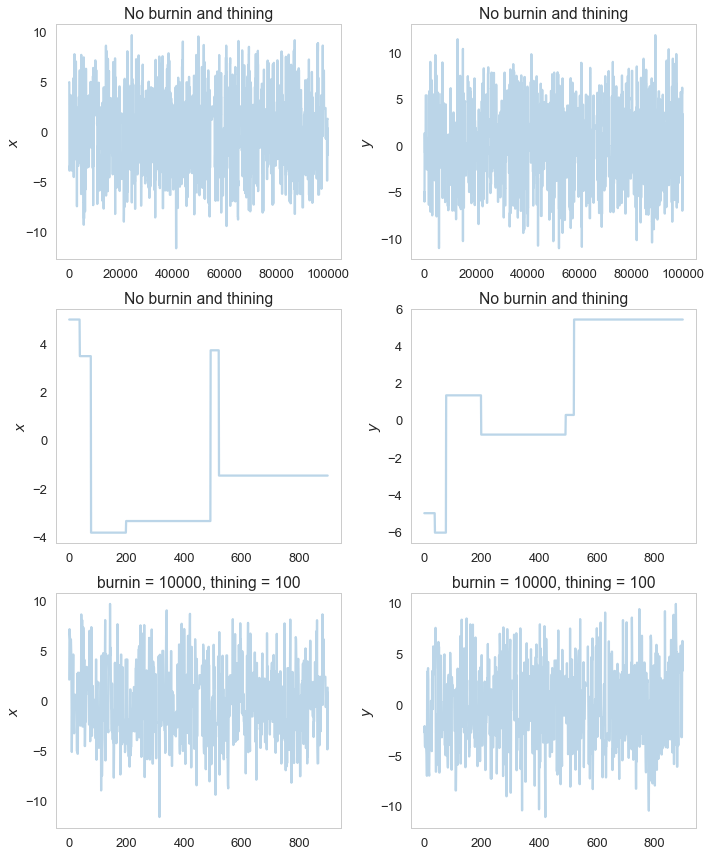

In [39]:
mhs[8].process(10000, 100)
traceplots(mhs[8])

beta = 40


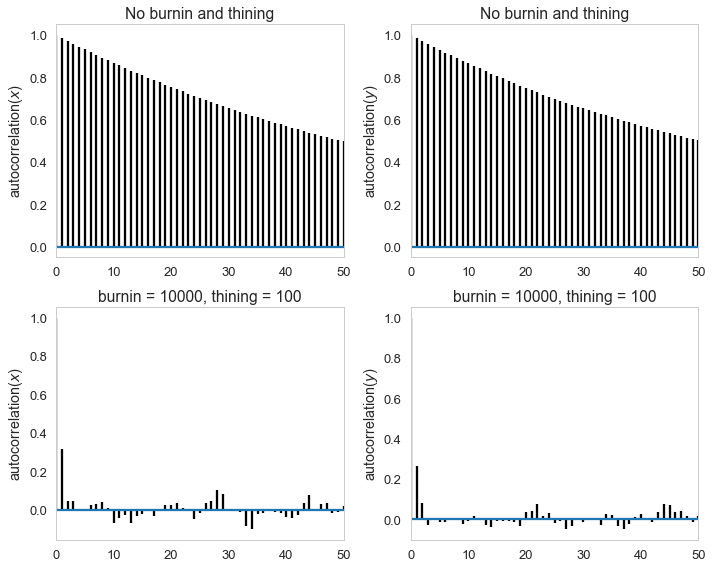

In [40]:
corrplots(mhs[8])

The autocorrelations are very strong when $\beta$ = 40.

#### 2. Explain your results and select the "best" value of $\beta$?

**Observations and explanations**:
1. The acceptance rate increases when $\beta$ increases from 0.1 to 0.5, and decreases when $\beta$ increases from 0.5 to 40. In general, lower acceptance rate is expected for larger step size (i.e., larger $\beta$). In this case, the "offset" in the proposal function plays a significant role in lowering the acceptance rate when $\beta$ is too small; thus we observe positive correlation between acceptance rate and $\beta$ for the first few small $\beta$s. We observe negative correlation between acceptance rate and $\beta$ when $\beta$ is large enough to counteract the effect of the "offset" in the proposal function.
2. The autocorrelations are strong when the acceptance rate is too low or too high. When the acceptance rate is low, the sampler would stay at the same location for a long time until it accepts a new value, which would result in strong autocorrelations. High acceptance rate is usually due to small step size; the sampler is more likely to explore nearby locations at each iteration, also resulting in strong autocorrelations.

**The "best" value of $\beta$ is 5.** The reasons are as follows:
1. The acceptance rate is neither too low nor too high.
2. The autocorrelations are the weakest when $\beta$ = 5. And thining at 10 can generate very good result.

We plot samples for $\beta$ = 5 as follows.

beta = 5
No burnin and thining.
Wall time: 491 ms


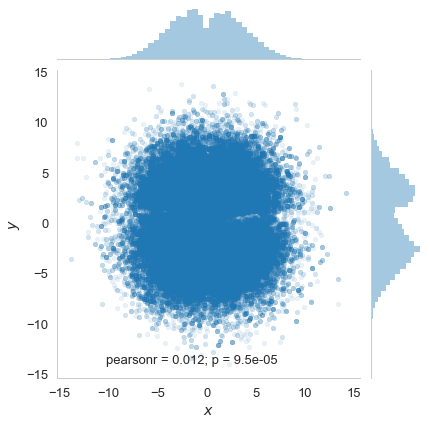

In [41]:
%%time
print('beta = {}'.format(mhs[5].beta))
print('No burnin and thining.')
g = sns.jointplot(x=0, y=1, data=pd.DataFrame(mhs[5].samples), marker='.');
g.ax_joint.collections[0].set_alpha(0.1);
g.set_axis_labels('$x$', '$y$');

beta = 5
No burnin and thining.
Wall time: 1min 10s


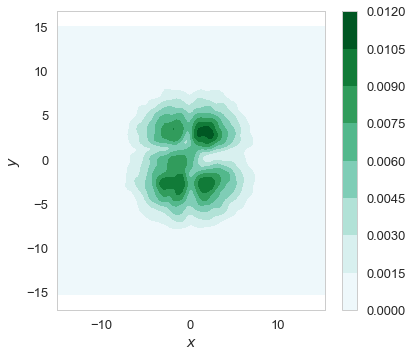

In [42]:
%%time
print('beta = {}'.format(mhs[5].beta))
print('No burnin and thining.')
plt.figure(figsize=(6, 5.5))
sns.kdeplot(mhs[5].samples[:, 0], mhs[5].samples[:, 1], shade=True, cbar=True);
plt.xlabel('$x$');
plt.ylabel('$y$');
plt.axis('equal');

beta = 5
burnin = 10000, thining = 10
Wall time: 275 ms


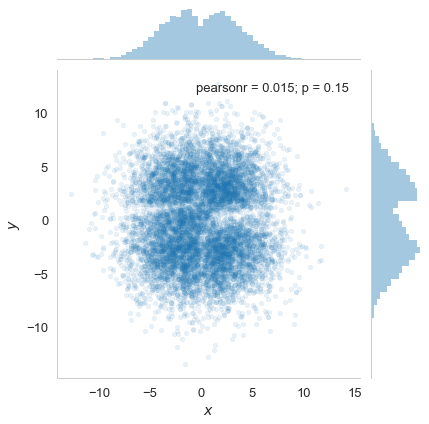

In [43]:
%%time
print('beta = {}'.format(mhs[5].beta))
print('burnin = {}, thining = {}'.format(mhs[5].burnin, mhs[5].thin))
g = sns.jointplot(x=0, y=1, data=pd.DataFrame(mhs[5].samples2), marker='.');
g.ax_joint.collections[0].set_alpha(0.1);
g.set_axis_labels('$x$', '$y$');

beta = 5
burnin = 10000, thining = 10
Wall time: 4.78 s


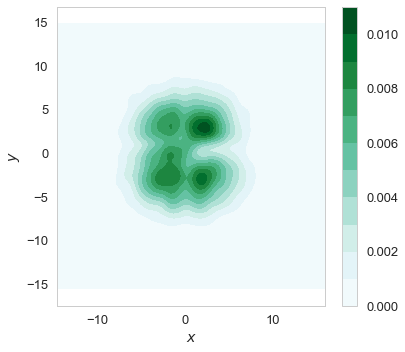

In [44]:
%%time
print('beta = {}'.format(mhs[5].beta))
print('burnin = {}, thining = {}'.format(mhs[5].burnin, mhs[5].thin))
plt.figure(figsize=(6, 5.5))
sns.kdeplot(mhs[5].samples2[:, 0], mhs[5].samples2[:, 1], shade=True, cbar=True);
plt.xlabel('$x$');
plt.ylabel('$y$');
plt.axis('equal');

The results look very similar to what we get in Part A.

We sample more to get 100,000 samples after burnin and thining.

In [45]:
%%time
mh2 = Metropolis_Hastings(beta=5).run(n=1010000, x_init=np.array([5, -5])).process(10000, 10)

Wall time: 3min 55s


beta = 5
burnin = 10000, thining = 10


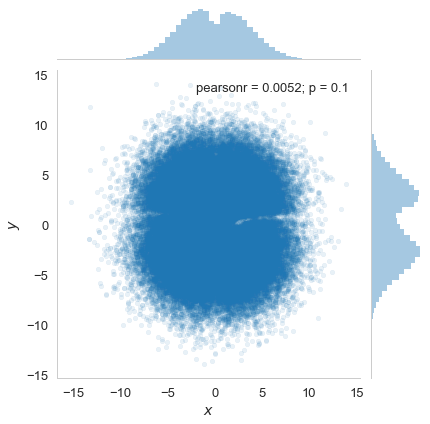

In [46]:
print('beta = {}'.format(mh2.beta))
print('burnin = {}, thining = {}'.format(mh2.burnin, mh2.thin))
g = sns.jointplot(x=0, y=1, data=pd.DataFrame(mh2.samples2), marker='.');
g.ax_joint.collections[0].set_alpha(0.1);
g.set_axis_labels('$x$', '$y$');

beta = 5
burnin = 10000, thining = 10


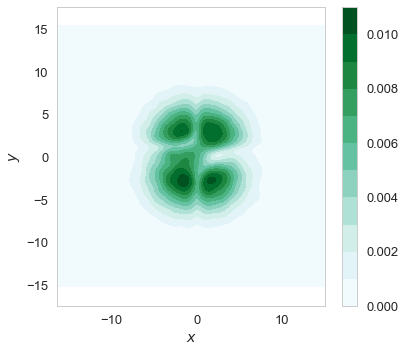

In [47]:
print('beta = {}'.format(mh2.beta))
print('burnin = {}, thining = {}'.format(mh2.burnin, mh2.thin))
plt.figure(figsize=(6, 5.5))
sns.kdeplot(mh2.samples2[:, 0], mh2.samples2[:, 1], shade=True, cbar=True);
plt.xlabel('$x$');
plt.ylabel('$y$');
plt.axis('equal');

As we can see, the results are very similar.

### Answer to Problem 2 Part C

In [48]:
def F(x, sigma2=10):
    return np.exp(-np.sum(np.square(x))/2/sigma2) * np.log(1 + (1.5-x[0]+x[0]*x[1])**2 \
                                                           + (2.25-x[0]+x[0]*x[1]*x[1])**2 \
                                                           + (2.625-x[0]+x[0]*x[1]**3)**2)

def q_draw2(x, beta=1):
    return np.random.multivariate_normal(x, [[beta**2, 0], [0, beta**2]])

class Metropolis:
    def __init__(self, beta=5, dim=2):
        self.dim = dim
        self.p = F
        self.q_draw = partial(q_draw2, beta=beta)
        self.beta = beta
        
    def run(self, n=100000, x_init=np.array([5, -5])):
        start = time.time()
        p = self.p
        q_draw = self.q_draw
        samples = np.empty((n, self.dim))
        x_prev = x_init
        accepted = 0
        for i in range(n):
            x_star = q_draw(x_prev)
            p_star = p(x_star)
            p_prev = p(x_prev)
            pdfratio = p_star / p_prev
            if np.random.uniform() < min(1, pdfratio):
                samples[i] = x_star
                x_prev = x_star
                accepted += 1
            else:
                samples[i] = x_prev
        self.x_init = x_init
        self.n = n
        self.accepted = accepted
        self.accepted_ratio = accepted / n
        self.samples = samples
        self.samples_prob = np.array([p(x) for x in samples])
        self.time_ = time.time() - start
        return self
    
    def process(self, burnin, thin):
        self.burnin = burnin
        self.thin = thin
        self.samples2 = self.samples[burnin::thin]
        self.samples2_prob = self.samples_prob[burnin::thin]
        return self
    

After several trials, we decide to choose a bivariate normal with covariance [[25, 0], [0, 25]] (centered at current position) as the proposal distribution.

In [49]:
%%time
print('Metropolis')
m = Metropolis(beta=5).run(n=100000, x_init=np.array([5, -5]))
print('Acceptance rate: {}.'.format(m.accepted_ratio))

Metropolis
Acceptance rate: 0.42128.
Wall time: 20.4 s


The acceptance rate is neither too high or too low, and is slightly higher than that of the $\beta$ = 5 case in Part B. 

beta = 5


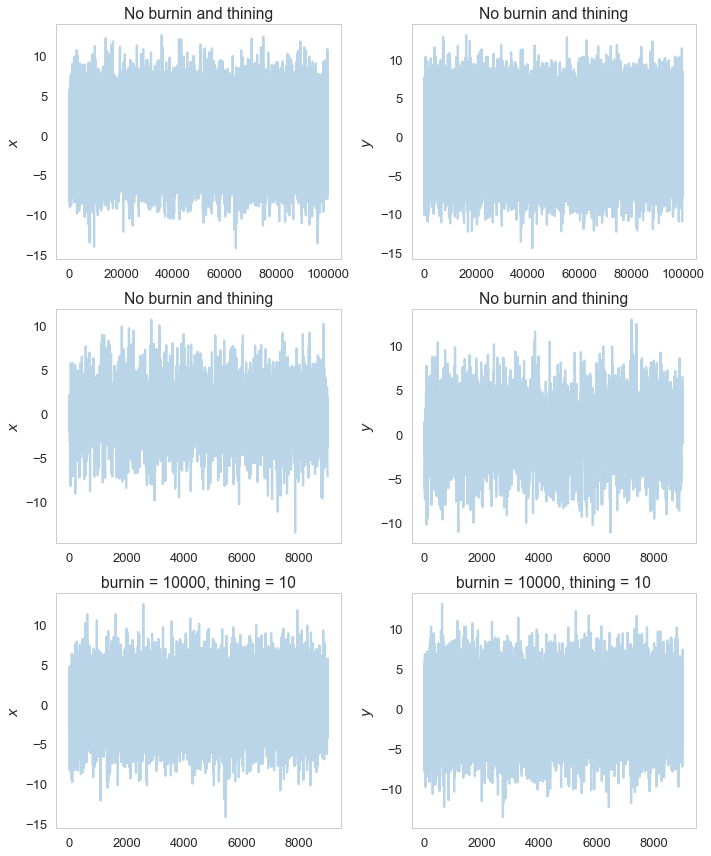

In [50]:
m.process(10000, 10)
traceplots(m)

beta = 5


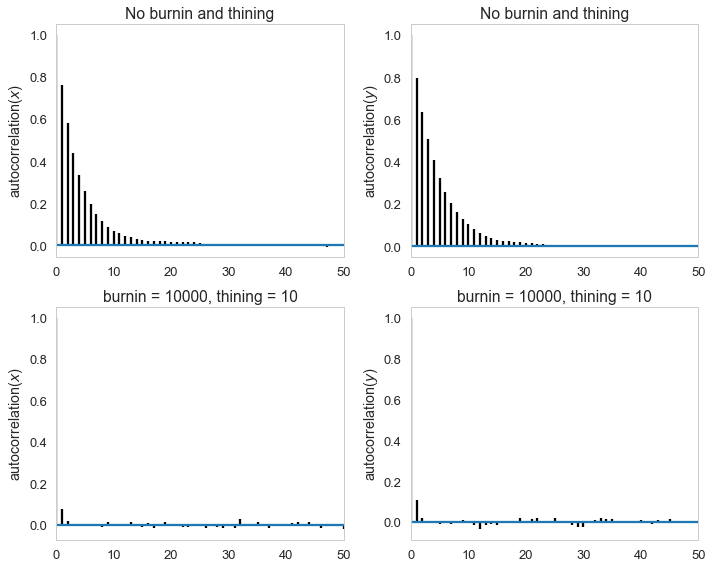

In [51]:
corrplots(m)

The autocorrelations are not strong, and can be eliminated by setting thining to be 10, which is also similar to $\beta$ = 5 case in Part B.

We plot samples before and after burnin and thining as follows.

No burnin and thining.


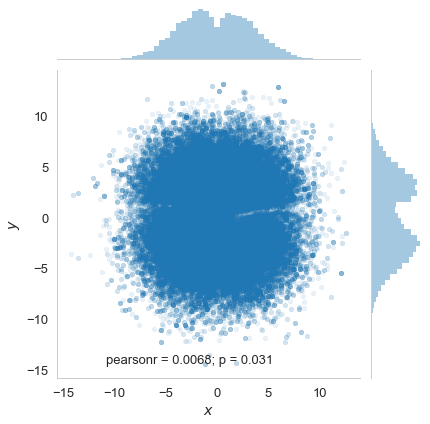

In [52]:
print('No burnin and thining.')
g = sns.jointplot(x=0, y=1, data=pd.DataFrame(m.samples), marker='.');
g.ax_joint.collections[0].set_alpha(0.1);
g.set_axis_labels('$x$', '$y$');

No burnin and thining.


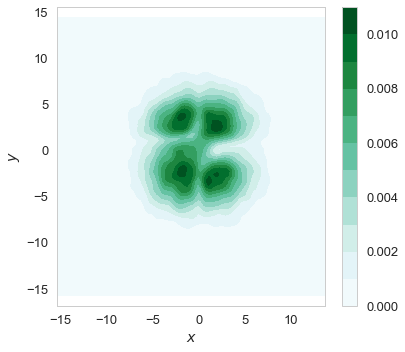

In [53]:
print('No burnin and thining.')
plt.figure(figsize=(6, 5.5))
sns.kdeplot(m.samples[:, 0], m.samples[:, 1], shade=True, cbar=True);
plt.xlabel('$x$');
plt.ylabel('$y$');
plt.axis('equal');

burnin = 10000, thining = 10


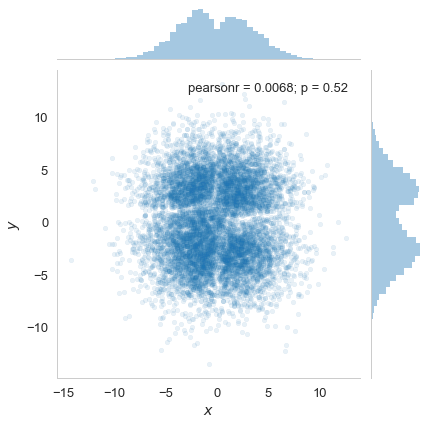

In [54]:
print('burnin = {}, thining = {}'.format(m.burnin, m.thin))
g = sns.jointplot(x=0, y=1, data=pd.DataFrame(m.samples2), marker='.');
g.ax_joint.collections[0].set_alpha(0.1);
g.set_axis_labels('$x$', '$y$');

burnin = 10000, thining = 10


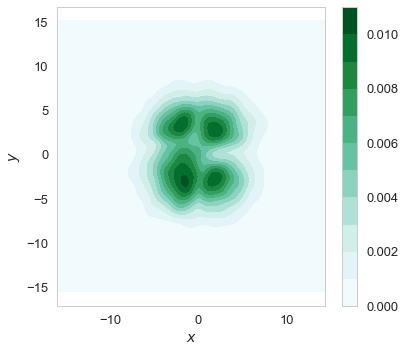

In [55]:
print('burnin = {}, thining = {}'.format(m.burnin, m.thin))
plt.figure(figsize=(6, 5.5))
sns.kdeplot(m.samples2[:, 0], m.samples2[:, 1], shade=True, cbar=True);
plt.xlabel('$x$');
plt.ylabel('$y$');
plt.axis('equal');

The distributions of samples are similar to those from Part A and Part B.

We sample more to get 100000 samples after burnin and thining.

In [56]:
%%time
m2 = Metropolis(beta=5).run(n=1010000, x_init=np.array([5, -5])).process(10000, 10)

Wall time: 3min 31s


beta = 5
burnin = 10000, thining = 10


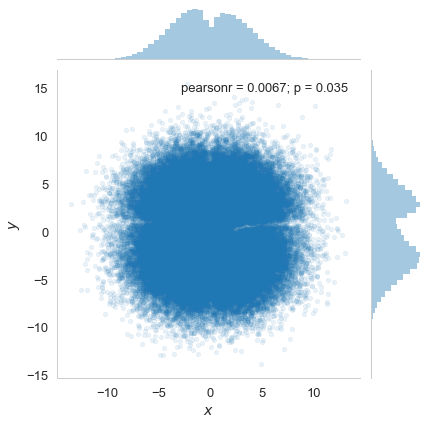

In [57]:
print('beta = {}'.format(m2.beta))
print('burnin = {}, thining = {}'.format(m2.burnin, m2.thin))
g = sns.jointplot(x=0, y=1, data=pd.DataFrame(m2.samples2), marker='.');
g.ax_joint.collections[0].set_alpha(0.1);
g.set_axis_labels('$x$', '$y$');

beta = 5
burnin = 10000, thining = 10


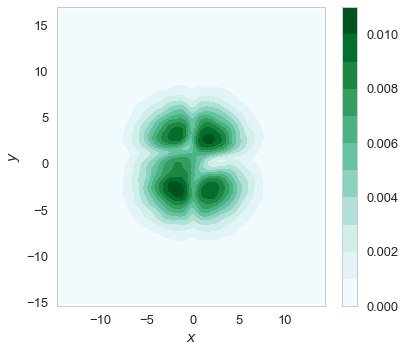

In [58]:
print('beta = {}'.format(m2.beta))
print('burnin = {}, thining = {}'.format(m2.burnin, m2.thin))
plt.figure(figsize=(6, 5.5))
sns.kdeplot(m2.samples2[:, 0], m2.samples2[:, 1], shade=True, cbar=True);
plt.xlabel('$x$');
plt.ylabel('$y$');
plt.axis('equal');

The results are very similar to those from Part A and Part B.